# Análise das notícias sob a ótica ESG: geração da base com sentimentos

- Autor: Daniel Saraiva Leite - 2023
- Projeto Análise de sentimentos sobre notícias do tema ESG
- Trabalho de conclusão de curso - MBA Digital Business USP Esalq

In [1]:
import warnings
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import datetime  as dt
from scipy import interpolate
import scipy.stats
from noticias_timeline import plota_timeline
from noticias_processamento_texto import *
from vaderSentimentptbr import SentimentIntensityAnalyzer 
from sumarizador_textrankptbr import summarize_text_rank 
from analise_sentimento_modelo import *
from noticias_graficos import *
from classificador_esg import aplica_classificador_esg
import pickle

warnings.filterwarnings('ignore')
base_noticias = 'datasets/base_noticias.xlsx'
base_noticias_saida = 'datasets/sentimento_base_noticias.xlsx'

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lendo base de notícias

In [2]:
df = pd.read_excel(base_noticias)

df['fonte'] = df['fonte'].apply(trata_nome_fontes)
df['data_publicacao'] = df['data_publicacao'].dt.date
df = df.sort_values(by=['empresa', 'data_publicacao'])
df['titulo_par'] = df['titulo'].str.strip().apply(remove_acentos).str[:15]
df = df.drop_duplicates(subset=['empresa', 'fonte', 'data_publicacao', 'titulo_par'], keep='last')
del df['titulo_par']

## Pré-processamento da base de notícias
- Aplica um classificador SVM as noticias, indicando se sao E, S ou G, ou Outros (caso em que serão descartadas). O classificador é construido no treino_classificador_esg.ipynb
- Realiza filtro
- Resume o texto pelo algoritmo TextRank (Mihalcea, 2014): https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

In [3]:
# utiliza o classificador por ML para determinar o assunto da noticia: E, S, G ou outros
vect = pickle.load(open('models/SVCC=0.2, kernel=linear, probability=True_vectorizer_esg_classifier.sav', 'rb'))
model = pickle.load(open('models/SVCC=0.2, kernel=linear, probability=True_classifier_esg_classifier.sav', 'rb'))

df = df[~pd.isnull(df['texto_completo'])]
df['classificacao'] = aplica_classificador_esg(vect, model, df, 
                             comparar_com_real=False, col_texto_origem='texto_completo', 
                             col_texto_saida='texto_ajustado', col_classe_verdadeira='classificacao')



# filtros pos processamento (exclusoes). Nessa etapa excluem-se as noticias com classificacao=Outros
df = filtrar_noticias_pos_coleta(df)

# ajustes
df['empresa'] = df['empresa'].str.replace(' s.a.', '')

# resume o texto filtrando partes nao relevantes
df['resumo'] = df['texto_completo'].apply(lambda x : summarize_text_rank(x, compression=0.8, include_first_parag=True))

## Aplicação do algoritmo de análise de sentimento VADER adaptado ao português
Referências:
Gilbert, CJ Hutto Eric. 2014. Vader: A parsimonious rule-based model for sentiment analysis of social media text.
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Disponível em: <http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf>


In [4]:
s = SentimentIntensityAnalyzer() 
df['polaridade_texto'] = df['resumo'].apply(lambda x : s.polarity_scores(x)['compound'] )
df['polaridade_titulo'] = df['titulo'].apply(lambda x : s.polarity_scores(x)['compound'] )

# pondera heuristicamente titulo e texto
df['polaridade'] = pondera_polaridade_titulo_texto(df['polaridade_titulo'] , df['polaridade_texto'])


df.to_excel(base_noticias_saida, index=False)

## Descrevendo o conjunto de dados

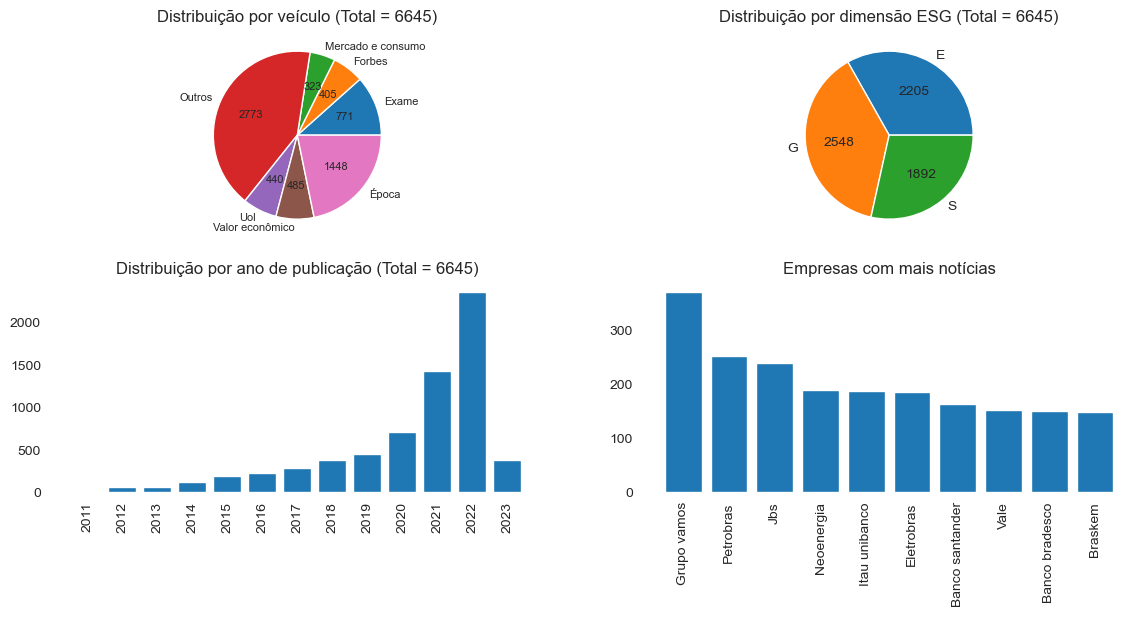

In [5]:
df = pd.read_excel(base_noticias_saida)

    
plotar_descricao_base(df, plotar_histograma=False, arquivo=r'static/images/descricao_base.png')

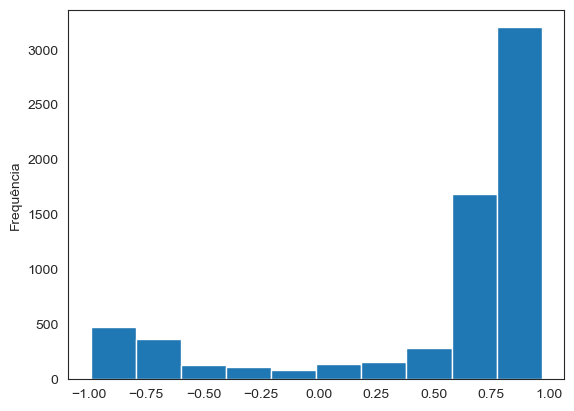

In [6]:
df['polaridade'].plot.hist().set_ylabel('Frequência')
plt.savefig(r'static/images/histograma_base.png', bbox_inches='tight')
plt.show()

## Definindo a empresa para análise específica

In [49]:
empresa = 'banco btg pactual'
dfEmpresa = df[df['empresa'] == empresa]

## Executando o modelo de polaridade média (EWMA)

In [50]:
lista_dfs_polaridade = [gera_curva_polaridade_media(df, empresa, 'ESG', alfa=0.1),
                        gera_curva_polaridade_media(df, empresa, 'E', alfa=0.1),
                        gera_curva_polaridade_media(df, empresa, 'S', alfa=0.1),
                        gera_curva_polaridade_media(df, empresa, 'G', alfa=0.1)]

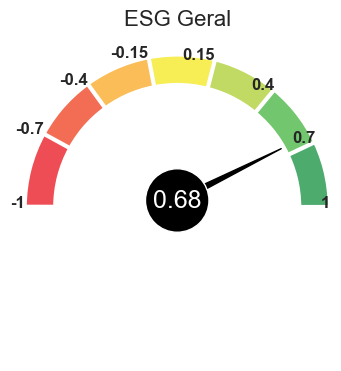

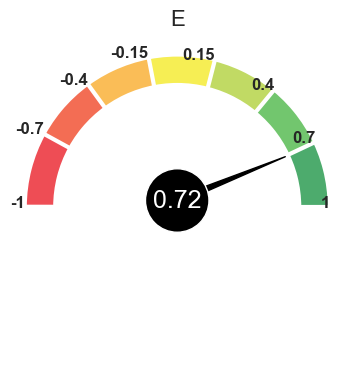

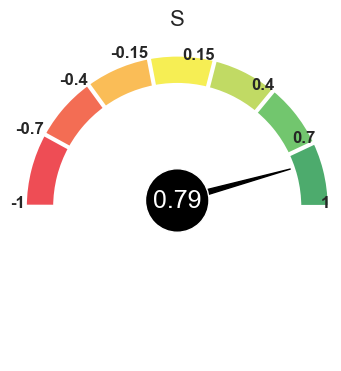

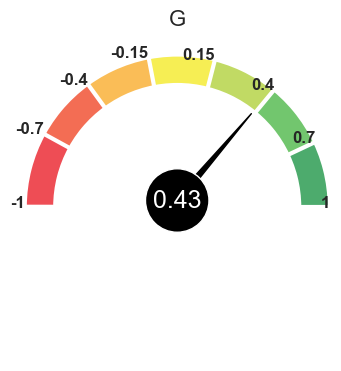

In [51]:
plotar_gauge_polaridade(df, empresa=empresa, dimensao='ESG', df_pol=lista_dfs_polaridade[0])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='E', df_pol=lista_dfs_polaridade[1])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='S', df_pol=lista_dfs_polaridade[2])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='G', df_pol=lista_dfs_polaridade[3])

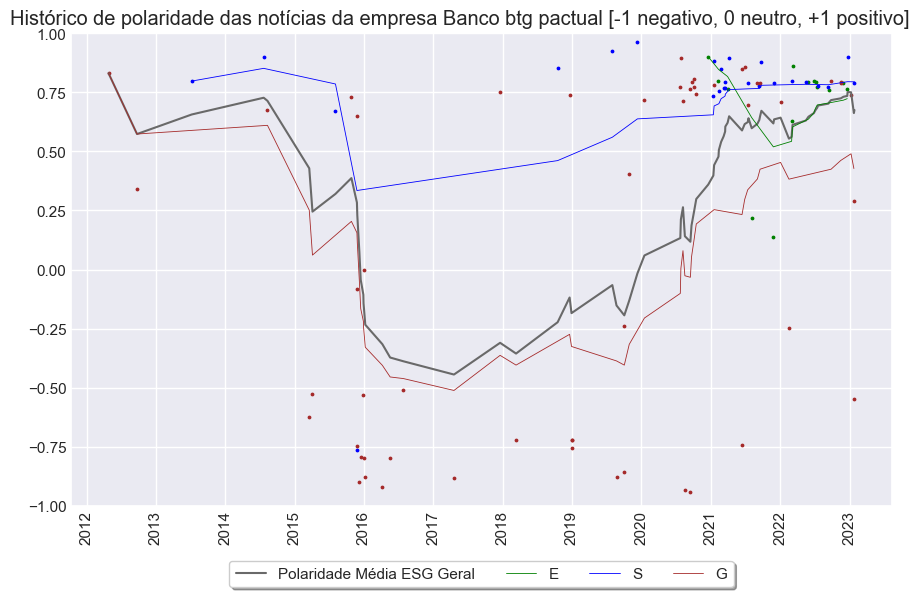

In [52]:
plota_polaridade_media_sintetico(df, empresa, arquivo=r'static/images/pol_media_sintetico.png', lista_dfs_polaridade=lista_dfs_polaridade)

## Amostra de notícias para a empresa

26/04/2012: Recursos do IPO do BTG irão para ampliar negócios - Época NEGÓCIOS [G 0.83]
23/09/2012: Sócio da Vale na África quer processar BTG e Agnelli - Época NEGÓCIOS [G 0.34]
08/07/2013: A turma do interior - Época NEGÓCIOS [S 0.80]
22/07/2014: As 7 lições de André Esteves para ter uma carreira de sucesso - Época NEGÓCIOS [S 0.90]
11/08/2014: BTG quer ser mais do que um banco global - Época NEGÓCIOS [G 0.67]
04/08/2015: "Não há nada errado em ter ambição e querer ganhar dinheiro. É isso que move as sociedades" - Época NEGÓCIOS [S 0.67]
27/10/2015: Telefônica vende cabos submarinos por R$ 460 milhões - Época NEGÓCIOS [G 0.73]
18/12/2017: Aplicar em PGBL pode reduzir imposto, mas há restrições - Época NEGÓCIOS [G 0.75]
17/10/2018: A transformação virá de quem não tem medo de questionar, diz chefe de RH do BTG Pactual - Época NEGÓCIOS [S 0.85]
19/12/2018: XP e BTG Pactual travam batalha na Justiça sobre concorrência desleal - UOL [G 0.74]
01/08/2019: "Interagir com startups nos torna 

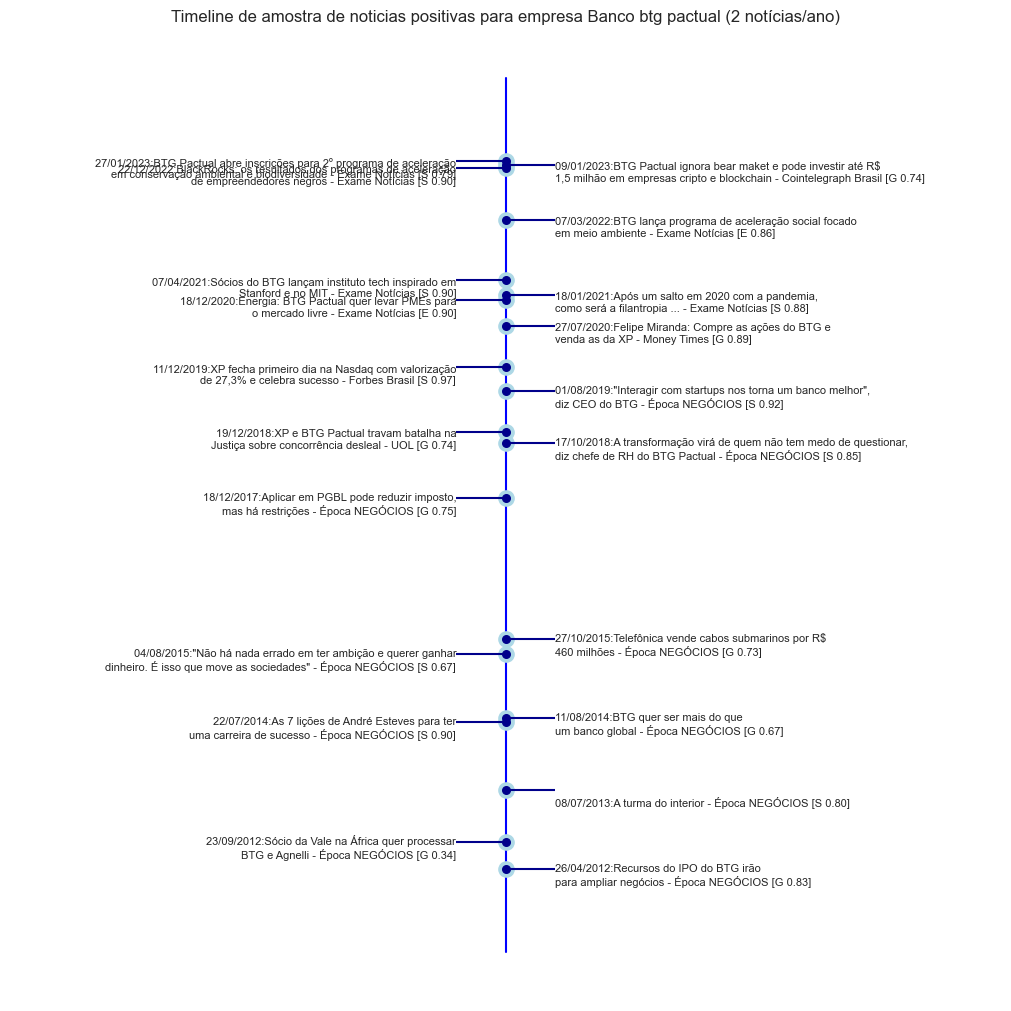

In [53]:
plota_timeline_polaridade(dfEmpresa, +1, 2, empresa )

08/12/2015: Capítulo a capítulo: O drama do BTG, após a prisão de André Esteves - Época NEGÓCIOS [G -0.90]
30/12/2015: O que parecia mentira,mas foi notícia em 2015 - Época NEGÓCIOS [G -0.80]
08/01/2016: Comitê do BC recomendou inabilitação de Esteves em 2010 por perdas no Pactual - Época NEGÓCIOS [G -0.88]
07/04/2016: Ex-presidente da Andrade Gutierrez negou irregularidades no caso Gamecorp - Época NEGÓCIOS [G -0.92]
19/04/2017: Juiz da Conclave quebra sigilo de André Esteves - Época NEGÓCIOS [G -0.88]
12/03/2018: André Esteves se prepara para voltar ao comando do BTG - Época NEGÓCIOS [G -0.72]
29/12/2018: Fundador do BTG Pactual volta a grupo de controle - Forbes Brasil [G -0.75]
23/08/2019: PF usa delação de Palocci e faz buscas contra André Esteves, do BTG, e ex-Petrobras - UOL [G -0.88]
03/10/2019: Mantega vazou informações sobre taxa Selic para André Esteves, disse Palocci - UOL Economia [G -0.86]
17/08/2020: Delação desmentida pela PF favorece Lula e pode incriminar Palocci, diz

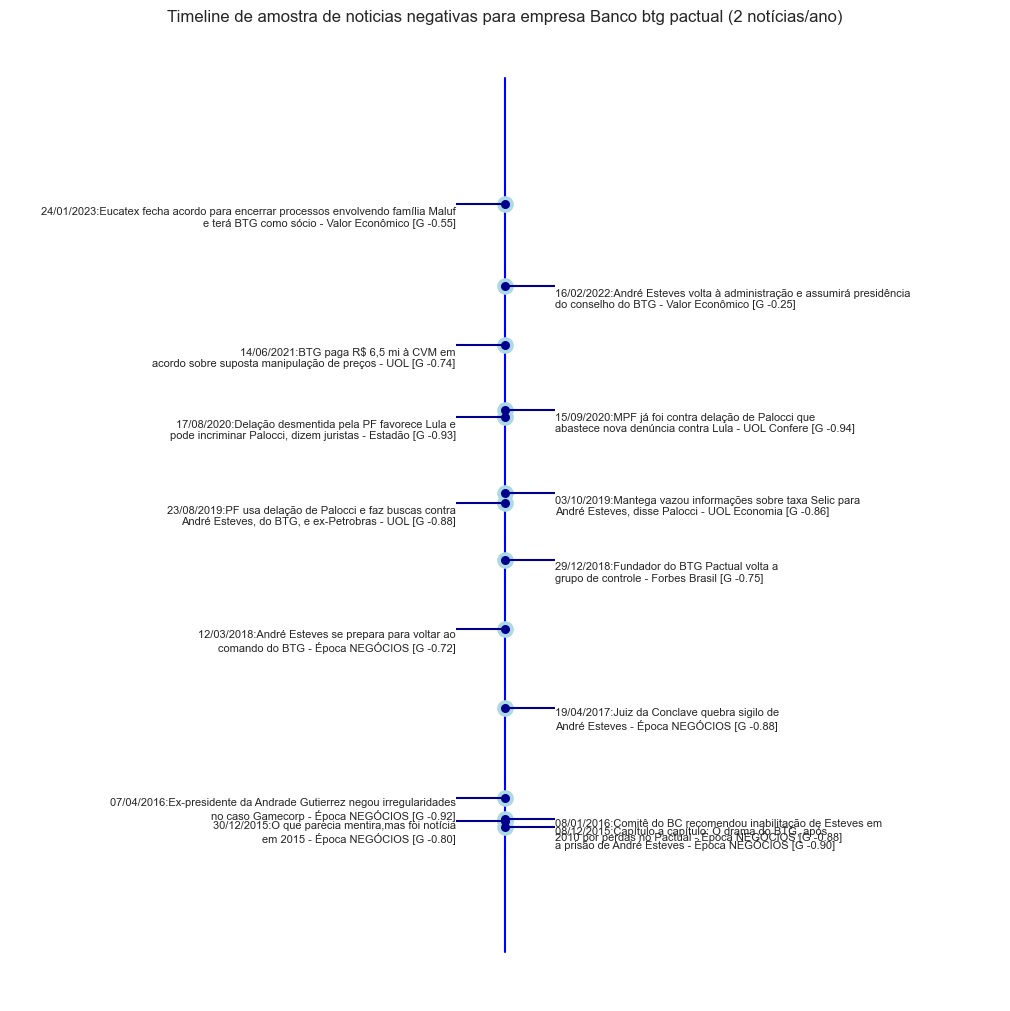

In [54]:
plota_timeline_polaridade(dfEmpresa, -1, 2, empresa )

## Comparativo com Polaridade x B3

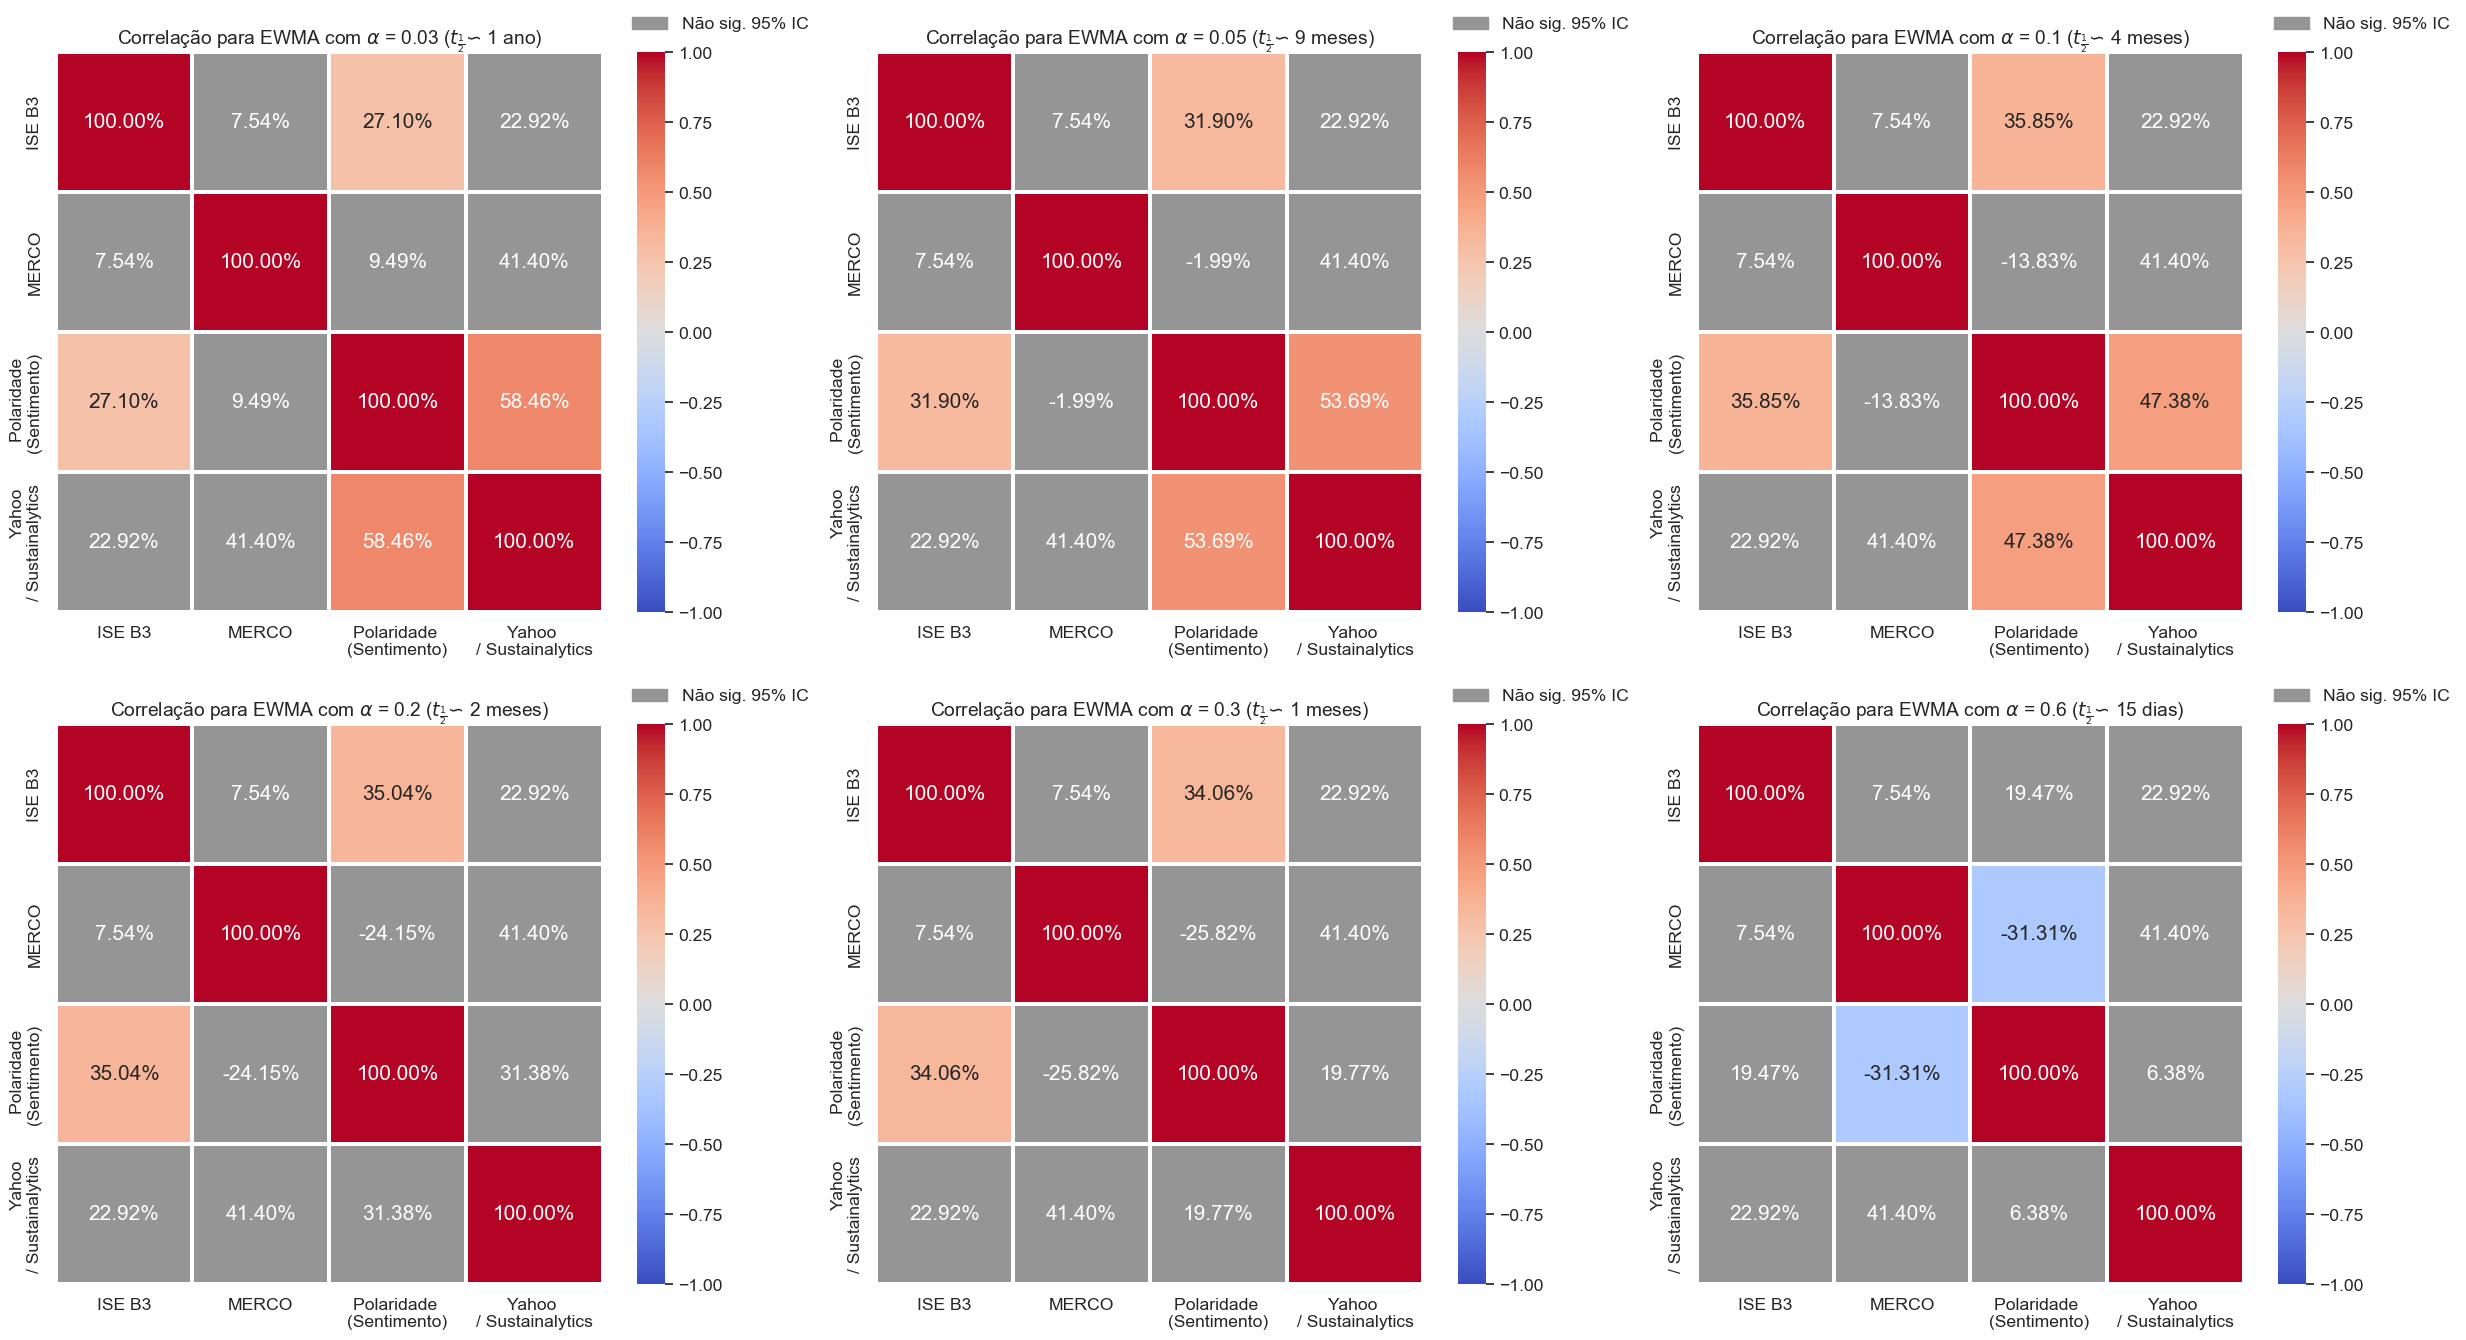

In [55]:
dfB3 = None

dfEmpresasComparar = pd.read_excel('datasets/lista_empresas.xlsx')
dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('datasets/EscoreMerco.xlsx'), on='Nome', how='left')

df_yahoo = pd.read_excel('datasets/escore_yahoo.xlsx')
df_yahoo = df_yahoo[df_yahoo.Date.dt.date <= dt.date(2023, 1, 1)]
df_yahoo = df_yahoo[df_yahoo.Date.dt.date >= dt.date(2021, 1, 1)]
df_yahoo = pd.merge(left=df_yahoo.groupby(by=['Nome'], as_index=False)['Date'].max(), 
                   right=df_yahoo.loc[:, ['Date', 'Nome', 'Escore_Yahoo_Norm' ]], 
                   on=['Nome', 'Date'], how='left')

dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=df_yahoo, on='Nome', how='left')  #Escore_Yahoo_Norm



data_analise = dt.date(2023, 1, 1)  

dfAnalise = df[df['data_publicacao'].dt.date <= data_analise ]

dfEmpresasComparar = dfEmpresasComparar[ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) | (~pd.isnull(dfEmpresasComparar['Escore Merco']))  | (~pd.isnull(dfEmpresasComparar['Escore_Yahoo_Norm']))  ]  # somente considera B3 ou MERCO



dfEmpresasComparar['QtdeNoticias'] =  dfEmpresasComparar.apply(lambda row: len(dfAnalise[dfAnalise.empresa == remove_acentos(row['Nome'].lower())]),  axis=1)

def obtem_ultima_polaridade_base100(dfAnalise, empresa, data_analise, alfa):
    
    dfRes = gera_curva_polaridade_media(dfAnalise, empresa=remove_acentos(empresa.lower()), dimensao='ESG', alfa=alfa)
    if dfRes is not None and len(dfRes) > 0:
        return 100.0 * dfRes['polaridade_fit'].iloc[-1]
    else:
        return None
        
        
qtde_minima = 18
dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=0.1) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)
dfEmpresasComparar.to_excel('datasets/resultado_comp_rankings.xlsx')

rankings = {'Polaridade' : 'Polaridade (Sentimento)', 
            'SCORE ISE B3' : 'ISE B3', 
            'Escore Merco': 'MERCO', 
            'Escore_Yahoo_Norm' : 'Yahoo / Sustainalytics'}

dfEmpresasComparar = dfEmpresasComparar.loc[:, ['Nome'] + list(rankings.keys()) + ['QtdeNoticias']].drop_duplicates()

def correl_ranking(dfEmpresasComparar, a, b, p_valor=0):
    return scipy.stats.spearmanr(dfEmpresasComparar[a], dfEmpresasComparar[b])[p_valor]

df_resultado_correl = None
    
for a in [0.03, 0.05, 0.1, 0.2,  0.3, 0.6]:
    
    dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=a) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)    
    
    pares = [(a, b) for idx, a in enumerate(rankings.keys()) for b in list(rankings.keys())[idx + 1:]]
    for p in pares:
        
        df_correl_par = dfEmpresasComparar[['Nome', p[0], p[1]]][ (~pd.isnull(dfEmpresasComparar[p[0]])) &  (~pd.isnull(dfEmpresasComparar[p[1]])) ].drop_duplicates()
        

        correl = correl_ranking(df_correl_par, p[0], p[1])
        pvalor = correl_ranking(df_correl_par, p[0], p[1], p_valor=1)

        df_correl_par_resultado = pd.DataFrame( {'Alfa' : [a], 'Ranking A': [rankings[p[0]]],
                                                 'Ranking B': [rankings[p[1]]], 'Correlação' : correl,
                                                 'P-valor' : pvalor
                                                })
        if df_resultado_correl is None:
            df_resultado_correl = df_correl_par_resultado
        else:
            df_resultado_correl = pd.concat([df_resultado_correl, df_correl_par_resultado])

df_resultado_correl.to_excel('datasets/resultado_correlacao.xlsx', index=False)


plotar_correlacao_rankings(df_resultado_correl)

## Média noticias por ano

In [16]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]

print(media_ano)

18.32367149758454
